In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [87]:
def get_data_mirror_numpy(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros(n_modes, dtype=complex)
    for i in range(n_modes):
        if use_WW_approx:
            g_tab[i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            g_tab[i] = g_0*np.sqrt(omega_tab[i] / L)*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]

    H_matrix[n_modes, n_modes] = omega_A

    ##off diagonal elements
    for i in range(n_modes):
        H_matrix[n_modes, i] = g_tab[i]
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])
    
    identity_matrix = np.eye(dim_subspace, dtype=complex)

    ##Operators of interest
    N_k_list = []
    N_A = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    for i in range(n_modes):
        N_k_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
        N_k_matrix[i,i] = 1
        N_k_list.append(N_k_matrix)
    N_A[n_modes, n_modes] = 1
    
    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    #basis of the Hilbert space
    basis = []
    for i in range(n_modes):
        basis_state = np.zeros(dim_subspace, dtype=complex)
        basis_state[i] = 1
        basis.append(basis_state)
    last_state = np.zeros(dim_subspace, dtype=complex)
    last_state[n_modes] = 1
    basis.append(last_state)

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        if k_tab[i] > 0:
            init_state += np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar) * basis[i]

    init_state = init_state / np.linalg.norm(init_state)
    
    #time evolution
    nb_time_pts = int(T/dt)
    times = [0]
    state_list = [init_state]

    for t in tqdm(range(nb_time_pts)):
        new_state = (identity_matrix - 1j*dt*H_matrix) @ state_list[-1]
        #try something stupid : divide by two each component of the state with a high energy
        for i in range(n_modes):
            if np.abs(k_tab[i]) > 2*omega_A:
                new_state[i] = new_state[i] / 2
                
        new_state = new_state / np.linalg.norm(new_state)
        state_list.append(new_state)
        times.append(times[-1] + dt)
 
    times = np.array(times)

    return times, k_tab, N_k_list, N_A, state_list

First test of the function

In [88]:
L = 10*pi
T = L/2
dt = 0.001

#width of the wave packet
sigma = L/16
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.7

#omega_A = 5
#omega_0 = omega_A * (1 - 2*pi*g_0**2 / L)
omega_A = 5
omega_0 = 5


omega_max = 3*omega_A
omega_max_axis = 1.1*15*omega_0



print("Coupling parameter at atom frequency: ", g_0*np.sqrt(omega_A / L))
print("delta_k = ", 2*pi/L)
print("number of time points = ", int(T/dt))

times, k_tab, N_k_list, N_A, state_list = get_data_mirror_numpy(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = True)

Coupling parameter at atom frequency:  0.2792595962810029
delta_k =  0.2
number of time points =  15707
Number of modes:  151


  0%|          | 0/15707 [00:00<?, ?it/s]

Treat the results

In [89]:
n_modes = len(k_tab)
nb_time_pts = len(times)
N_k_values = np.zeros((n_modes, nb_time_pts))
N_A_values = np.zeros(nb_time_pts)

for t in tqdm(range(nb_time_pts)):
    state = state_list[t]
    for i in range(n_modes):
        N_k_values[i,t] = np.abs(np.conjugate(state) @ N_k_list[i] @ state)
    N_A_values[t] = np.abs(np.conjugate(state) @ N_A @ state)

  0%|          | 0/15708 [00:00<?, ?it/s]

Check that the normalization is preserved

Sum of the occupation numbers at time t =  0.0  :  1.0
Sum of the occupation numbers at time t =  3.927  :  0.9987450547552866
Sum of the occupation numbers at time t =  7.854  :  0.8873051780372351
Sum of the occupation numbers at time t =  11.781  :  0.9961103563361071


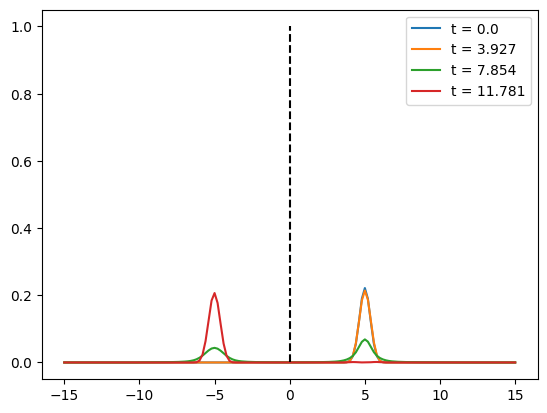

In [90]:
for t in range(0, nb_time_pts, nb_time_pts//4):
    plt.plot(k_tab, N_k_values[:,t], label = "t = "+str(t*dt))
    print("Sum of the occupation numbers at time t = ", t*dt, " : ", np.sum(N_k_values[:,t]))
plt.plot([0,0], [0,1], "k--")
plt.legend()
plt.show()

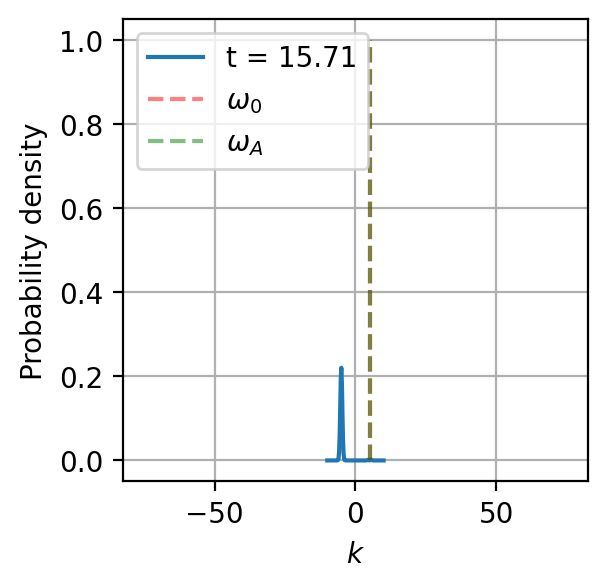

In [75]:
t_index = -1
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

#evolution of the probability density in position space
ax.plot(k_tab, N_k_values[:,t_index], label="t = {:.2f}".format(times[t_index]))
ax.set_xlim(-omega_max_axis, omega_max_axis)
ax.vlines(omega_0, 0, 1, color='r', linestyle='--', label=r'$\omega_0$', alpha=0.5)
ax.vlines(omega_A, 0, 1, color='g', linestyle='--', label=r'$\omega_A$', alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel(r'$k$')   
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

<h2> Occupation number of one specific mode </h2>

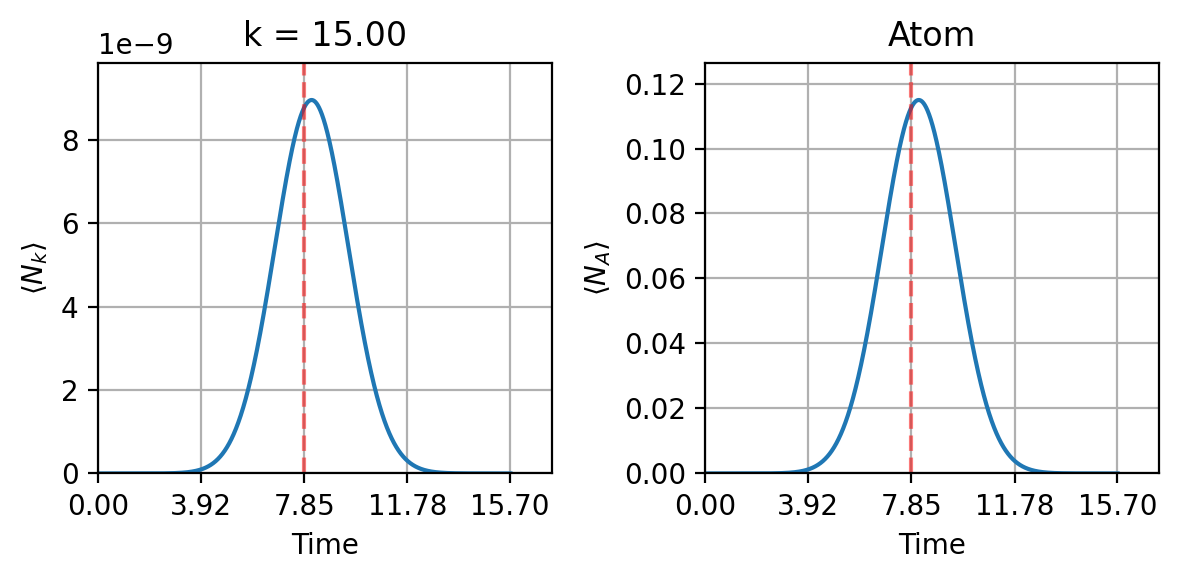

In [91]:
k_target = 3*omega_0
k_index = np.argmin(np.abs(k_tab - k_target))

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=resol)

ax[0].plot(times, N_k_values[k_index,:])
ax[0].set_xlim(0, 1.1*times[-1])
ax[0].set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax[0].set_xlabel('Time')
ax[0].vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax[0].set_ylim(0, 1.1*np.max(N_k_values[k_index,:]))
ax[0].set_ylabel(r'$\langle N_k \rangle$')
ax[0].set_title("k = {:.2f}".format(k_tab[k_index]))
ax[0].grid()

ax[1].plot(times, N_A_values)
ax[1].set_xlim(0, 1.1*times[-1])
ax[1].set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax[1].set_xlabel('Time')
ax[1].vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax[1].set_ylim(0, 1.1*np.max(N_A_values))
ax[1].set_ylabel(r'$\langle N_A \rangle$')
ax[1].set_title("Atom")
ax[1].grid()

fig.tight_layout()
plt.show()

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{k < 0} N_k \,\, , \,\, P_+(t) = \sum_{k > 0} N_k $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

T =  0.010154276136287313
R =  0.9898456655410759


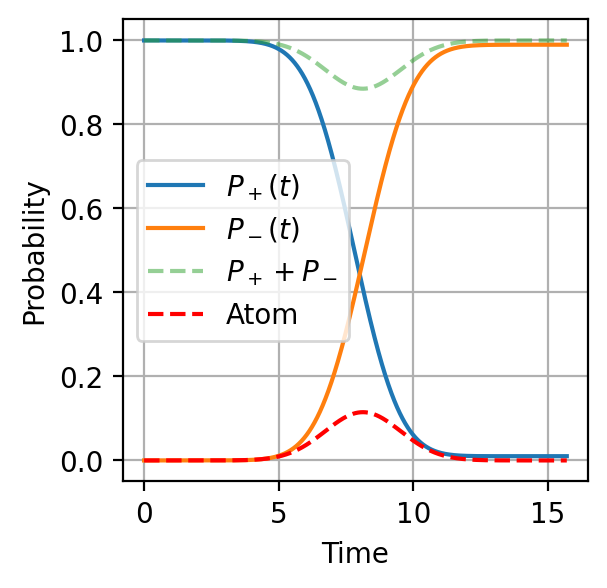

In [92]:
n_modes = len(k_tab)


nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_values[i,t]
        else:
            P_m[t] += N_k_values[i,t]

print("T = ", P_p[-1])
print("R = ", P_m[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_values, label='Atom', linestyle='--', color='red')   
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h1> Reflection against detuning ? </h1>

First, check the upper bound on g

In [4]:
L = 10*pi
n = 5
print(np.sqrt(L/(2*pi*n)))

1.0


In [29]:
L = 20*pi
N = 64
T = L/2
dt = 0.1
#number of atom
n_A = 1
x_A = 0
g_0 = 0.3

#width of the wave packet
sigma = L/16
x_0 = -L/4

omega_A = 5
omega_max = 2*omega_A

gamma = 2*pi*g_0**2 * omega_A / L

detunning_max = 10*gamma
if omega_A - detunning_max < 0:
    print("Bandwith too large")

print("Coupling parameter at atom frequency: ", g_0*np.sqrt(omega_A / L))

nb_freq = 17
omega_0_tab = np.linspace(omega_A + detunning_max, omega_A - detunning_max,nb_freq)

reflection_tab = np.zeros(nb_freq)
for t in tqdm(range(nb_freq)):
    if t == 0:
        print_nb_modes = True
    else:
        print_nb_modes = False
    omega_0 = omega_0_tab[t]
    times, k_tab, N_x_tab, N_k_tab, N_A_tab = get_data_mirror(L, N, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, print_nb_modes=print_nb_modes)
    #compute reflection coefficient
    N_k_tab = np.array(N_k_tab)
    n_modes = len(k_tab)

    R = 0
    for i in range(n_modes): 
        if k_tab[i] <= 0:
            R += N_k_tab[i,-1]
    reflection_tab[t] = R

Coupling parameter at atom frequency:  0.08462843753216344


  0%|          | 0/17 [00:00<?, ?it/s]

Number of modes:  201


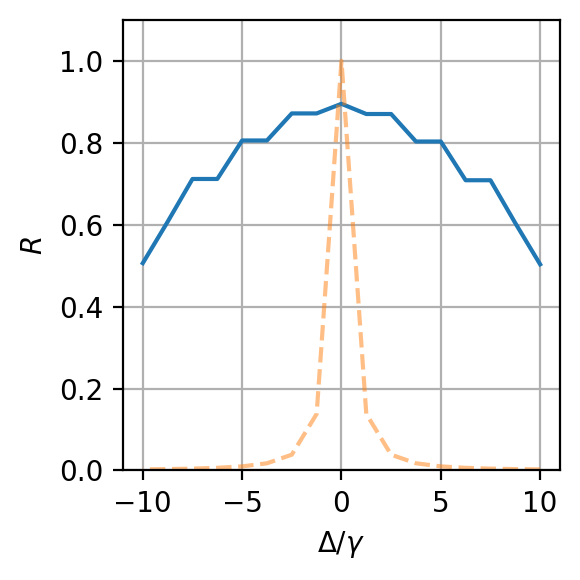

In [30]:
detunning_tab = omega_0_tab - omega_A

reflection_theory = 1 / (1 + 4*(detunning_tab / gamma)**2)

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(detunning_tab / gamma, reflection_tab, markersize=3)
ax.plot(detunning_tab / gamma, reflection_theory, linestyle='--', alpha=0.5)
ax.set_xlabel(r'$\Delta / \gamma$')
ax.set_ylabel(r'$R$')
ax.set_ylim(0,1.1)
ax.grid()

fig.tight_layout()
#plt.savefig("figures/mirror_reflection_nA_"+str(n_A)+"_omegaA_"+str(omega_A)+"_L_"+str(int(L//pi))+"pi.pdf")

plt.show()

Check for the behavior of a perfect mirror and a 50:50 BS

In [21]:
## find the frequency with highest reflection
max_reflection = np.max(reflection_tab)
index_max_reflection = np.argmax(reflection_tab)
omega_0_max_reflection = omega_0_tab[index_max_reflection]
print("Maximal reflection = ", max_reflection, " for omega_0 = ", omega_0_max_reflection)

## find the frequency with 0.5 reflection
index_half_reflection = np.argmin(np.abs(reflection_tab - 0.5))
effective_reflection = reflection_tab[index_half_reflection]
detunning_half_reflection = detunning_tab[index_half_reflection]
print("Half reflection = ", effective_reflection, " for omega_0 = ", omega_A - detunning_half_reflection, " or omega0 = ", omega_A + detunning_half_reflection)

Maximal reflection =  0.9493284112430272  for omega_0 =  5.091836734693877
Half reflection =  0.4825502467737229  for omega_0 =  6.561224489795919  or omega0 =  3.4387755102040813


<h1> UV Cut-off </h1>

Apparently, the UV cutoff has its importance ... let's check it

In [374]:
L = 5*pi
N = 64
T = L/2
dt = 0.1
#number of atom
n_A = 1
x_A = 0

#width of the wave packet
sigma = L/16
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies (supposed to have perfect reflection)
g_0 = 0.1
omega_A = 5
omega_0 = 15

nb_freq = 20
omega_max_tab = np.linspace(1, 20*omega_A, nb_freq-1)
omega_max_tab = np.concatenate((omega_max_tab, [2*omega_A]))
omega_max_tab = np.sort(omega_max_tab)
reflection_tab = np.zeros(nb_freq)


for x in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[x]
    times, k_tab, N_x_tab, N_k_tab, N_A_tab  = get_data_mirror(L, N, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, print_nb_modes=False)
    N_k_tab = np.array(N_k_tab)
    n_modes = len(k_tab)
    R = 0
    for i in range(n_modes): 
        if k_tab[i] <= 0:
            R += N_k_tab[i,-1]
    reflection_tab[x] = R

  0%|          | 0/20 [00:00<?, ?it/s]

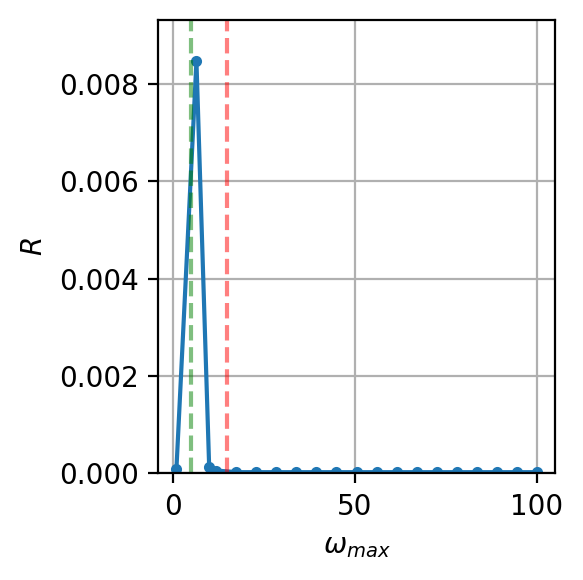

In [375]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab, reflection_tab, markersize=3, marker='o')
ax.vlines(omega_0, 0, 1, linestyle='--', color='red',alpha=0.5)
ax.vlines(omega_A, 0, 1, linestyle='--', color='green',alpha=0.5)
ax.set_xlabel(r'$\omega_{max}$')
ax.set_ylabel(r'$R$')
ax.set_ylim(0, np.max(reflection_tab)*1.1)
ax.grid()

fig.tight_layout()
plt.show()

<h1> Some test </h1>

In [338]:
def propagator_mirror(L, N, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, use_WW_approx = True, print_nb_modes = False, progress_bar = True):
    #space discretization
    position_lattice_list = np.linspace(-L/2, L/2, N)
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A / L)*np.exp(-1j*x_A*k_tab[i])*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i] / L)*np.exp(-1j*x_A*k_tab[i])*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + n_A
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    for i in range(n_A):
        H_matrix[n_modes+i, n_modes+i] = omega_A

    ##off diagonal elements
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[n_modes+j, i] = g_tab[i, j]
            H_matrix[i,n_modes+j] = np.conjugate(H_matrix[n_modes+j,i])

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    ##Operators of interest
    N_x_list = []
    N_k_list = []
    N_A = 0

    #occupation number operators in momentum space
    for i in range(n_modes):
        N_k_list.append(qt.basis(dim_subspace, i) * qt.basis(dim_subspace, i).dag())

    #Fourier transform to get the occupation number operators in position space
    for x in range(N):
        position = position_lattice_list[x]
        position_state = 0
        for i in range(n_modes):
            position_state += 1/np.sqrt(N) * np.exp(-1j * k_tab[i] * position) * qt.basis(dim_subspace, i)
        
        N_x_list.append(position_state * position_state.dag())
    
    for j in range(n_A):
        N_A += qt.basis(dim_subspace, n_modes + j) * qt.basis(dim_subspace, n_modes + j).dag()

    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = position_lattice_list[np.argmin(np.abs(position_lattice_list - x_0))]

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        if k_tab[i] > 0:
            init_state += np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar) * qt.basis(dim_subspace, i)

    #test : renormalize the state
    init_state = init_state.unit()
    init_state = init_state
    
    #time evolution
    nb_pts_time = int(T/dt)
    state_list = []
    times = np.array([0])

    state_list.append(init_state)
    infinitesimal_propagator = 1 - 1j * H * dt 

    for t in tqdm(range(nb_pts_time), disable=not progress_bar):
        new_state = infinitesimal_propagator * state_list[-1]
        new_state = new_state.unit()
        state_list.append(new_state)
        times = np.append(times, times[-1] + dt)

    return times, k_tab, state_list, N_x_list, N_k_list, N_A

Run same tests but with the new function

In [344]:
L = 5*pi
N = 64
T = L/2
dt = 0.001
#number of atom
n_A = 10
x_A = 0

#width of the wave packet
sigma = L/16
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 5
omega_0 = 5
omega_max = 10*omega_A


print("Coupling parameter at atom frequency: ", g_0*np.sqrt(omega_A / L))
print("delta_k = ", 2*pi/L)
print("number of time points = ", int(T/dt))

times, k_tab, state_list, N_x_list, N_k_list, N_A = propagator_mirror(L, N, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, print_nb_modes=True, use_WW_approx=True)

Coupling parameter at atom frequency:  0.28209479177387814
delta_k =  0.4
number of time points =  7853
Number of modes:  251


  0%|          | 0/7853 [00:00<?, ?it/s]

Treat the data

In [345]:
nb_pts_times = len(times)
n_modes = len(N_k_list)
N_k_values = np.zeros((n_modes, nb_pts_times))
N_A_values = np.zeros(nb_pts_times)

for t in tqdm(range(nb_pts_times)):
    for i in range(n_modes):
        #compute the expectation value but with 4-digit precision
        N_k_values[i,t] = np.abs(state_list[t].dag() * N_k_list[i] * state_list[t])
        #N_k_values[i,t] = np.round(N_k_values[i,t], 2)
    #now renormalize the occupation number
    #N_k_values[:,t] = N_k_values[:,t] / np.sum(N_k_values[:,t])
    
    N_A_values[t] = np.abs(state_list[t].dag() * N_A * state_list[t])

  0%|          | 0/7854 [00:00<?, ?it/s]

<h2> Results : momentum wave function </h2>

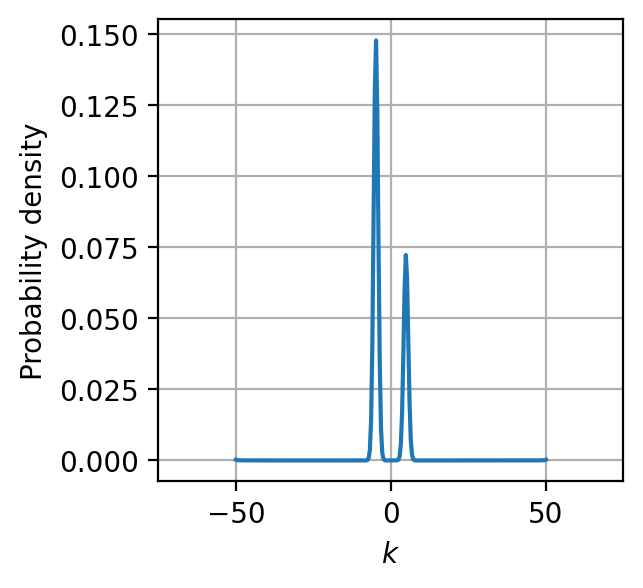

In [349]:
t_index = -1
omega_ax_lim = 15*omega_A

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
#evolution of the probability density in position sp§ace
ax.plot(k_tab, N_k_values[:,t_index], label="t = {:.2f}".format(times[t_index]))
ax.set_xlim(-omega_ax_lim, omega_ax_lim)
ax.set_xlabel(r'$k$')
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

Occupation number of specific mode

Final value :  0.07227388403429474


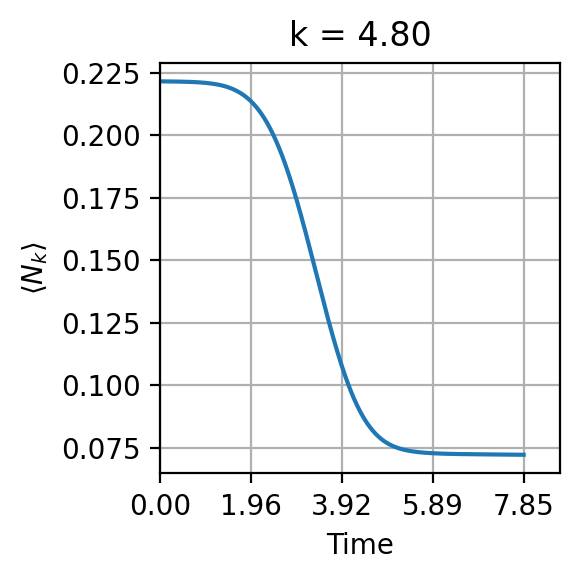

In [347]:
k_target = 1*omega_0
k_index = np.argmin(np.abs(k_tab - k_target))
print("Final value : ", N_k_values[k_index,-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, N_k_values[k_index,:])
ax.set_xlim(0, 1.1*times[-1])
ax.set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\langle N_k \rangle$')
ax.set_title("k = {:.2f}".format(k_tab[k_index]))
ax.grid()

fig.tight_layout()
plt.show()

Inspect each term

In [278]:
n_modes = len(k_tab)
occupation_tab_final = N_k_values[:,-1]
occupation_final_test = np.copy(occupation_tab_final)
threshold = 0.05

for i in range(n_modes):
    if occupation_tab_final[i] < threshold:
        occupation_final_test[i] = 0

#renormalize so that the sum is 100
occupation_final_test = occupation_final_test / np.sum(occupation_final_test)

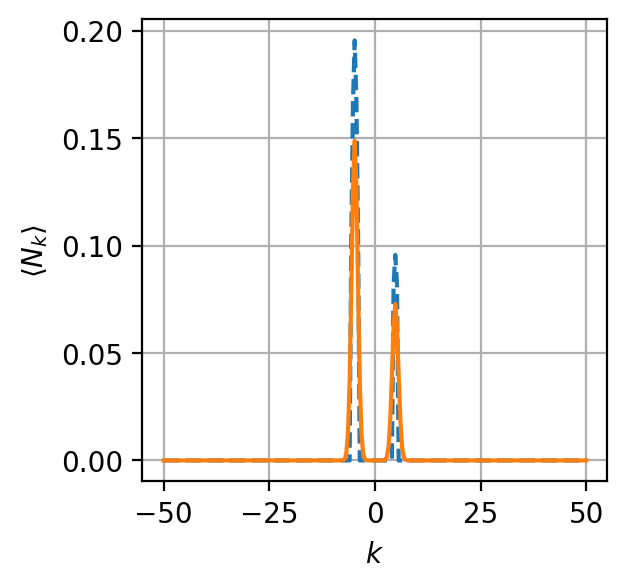

In [283]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)  
ax.plot(k_tab, occupation_final_test, label='Final occupation renormalized', linestyle='--')
ax.plot(k_tab, occupation_tab_final, label='Final occupation')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\langle N_k \rangle$')
#ax.legend()
ax.grid()

plt.show()

<h1> Reflection probability </h1>

T =  0.0016249495497180498
R =  0.9983750291832303
Sanity check: R + T = 0.9999999787329483


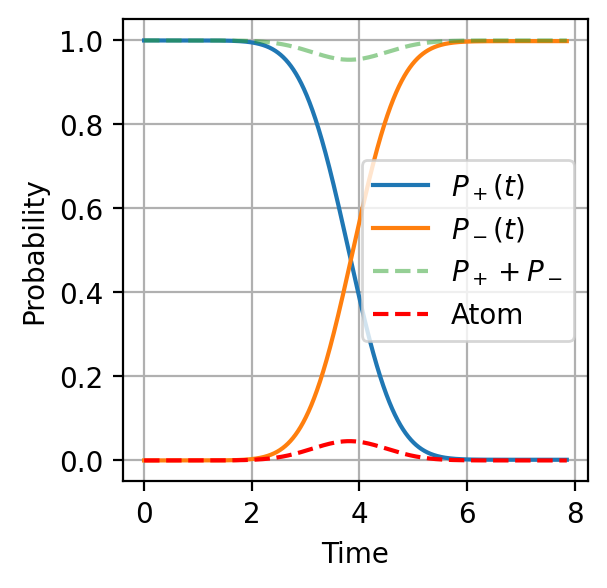

In [343]:
nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_values[i,t]
        else:
            P_m[t] += N_k_values[i,t]

print("T = ", P_p[-1])
print("R = ", P_m[-1])
print("Sanity check: R + T =", P_p[-1] + P_m[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_values, label='Atom', linestyle='--', color='red')   
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()